In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [76]:
data_path  = '../data/anonymized/'

In [9]:
slack = SlackDataLoader(path='../data/anonymized/')

In [77]:
channels = slack.get_channels()


In [20]:
users = slack.get_users()

In [39]:
#check the functions
# 
# utils.slack_parser(f"{dataPath}{channel[2]['name']}/")
utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")
# utils.parse_slack_reaction(f"{dataPath}{channel[2]['name']}/", channel[2]['name'])

{'U03UL5LSTG9': 26,
 'U03UJKJGRAQ': 15,
 'U03UVHCV6KB': 44,
 'U03TT5KEYCF': 42,
 'U03U93GNNVB': 96,
 'U03U1HAG9TR': 6,
 'U03UJGP0C68': 20,
 'U03UG1Z21JP': 15,
 'U03UJN29Y4C': 4,
 'U03U4GULU3Y': 28,
 'U03UHB8CXDY': 13,
 'U03V1AM5TFA': 3,
 'U03UG5VFN03': 2,
 'U03UD68RQH3': 10,
 'U03UG4Q7V42': 15,
 'U03UFV7HFNF': 6,
 'U03V61VGQG0': 17,
 'U03UUR571A5': 10,
 'U03UFV7TUTV': 2,
 'U03UUS0MZCZ': 1,
 'U03UJGRN5E0': 1,
 'U03V785NLSU': 9,
 'U03UJH1EQQL': 9,
 'U03UUMR26Q1': 8,
 'U03V6HMRPGQ': 18,
 'U03UH397319': 10,
 'U03U9FWPNCE': 1,
 'U03U9EJR362': 2,
 'U03UG0YHAUT': 12,
 'U03U1FNPEUX': 11,
 'U03UG32J3PC': 3,
 'U03UD5B7C3X': 6,
 'U03UUP56MDF': 2,
 'U03UAKATQ22': 3,
 'U03UG0SFHGT': 2,
 'U03TEPYRM2P': 2,
 'U03U1GHT39V': 1}

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [ ]:
   
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [ ]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## task 1- Perform EDA analysis to answer the following questions

<p>Who are the top and bottom 10 users by</p>

<li>Reply count?</li>

<li>Mention?</li>

<li> Message count?</li>

<li> Reaction count?</li>

In [146]:
# which user has the highest number of reply counts?

#use this utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")
#make this for all channels
user_reply_map = {}

for ch in channels:
    mpData = utils.get_community_participation(f"{data_path}{ch['name']}/")
    for user, reply_count in mpData.items():
        user_reply_map[user] = user_reply_map.get(user, 0) + reply_count
    

sorted_user_reply_map = dict(sorted(user_reply_map.items(), key=lambda item: item[1], reverse=True))

   
# for all channels find highest count with user then convert id to name
# Get the first key-value pair
highest_user_id, highest_reply_count = next(iter(sorted_user_reply_map.items()))


#get name_id from group

user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")
      
# Print the result
print(f"The user with the highest number of reply counts is {highest_user_name} with a count of {highest_reply_count}.")

The user with the highest number of reply counts is Amy with a count of 736.


In [147]:
# which user has the highest number of Mention?

import warnings
warnings.filterwarnings('ignore')
# what is the time range of the day that most messages are sent?

#get sent message with time, then group the with time 
# get_messages_from_channel use this function from utils

# Initialize an empty DataFrame
merged_df = pd.DataFrame(columns=['timestamp'])


#loop though channels
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.get_messages_from_channel(f"{data_path}{channel_name}/")
    for a in mp_data['ts']:
        # Convert the list to a DataFrame
        df = pd.DataFrame({'timestamp': pd.DataFrame(a, unit='s')})

        # Concatenate the current DataFrame to the merged DataFrame
        merged_df = pd.concat([merged_df, df], ignore_index=True)


In [ ]:
# which user has the highest number of Message count?

In [ ]:
# which user has the highest number of Reaction count?

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [148]:
# which user has the highest number of reply counts?

#use this utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")
#make this for all channels
user_reply_map = {}

for ch in channels:
    mpData = utils.get_community_participation(f"{data_path}{ch['name']}/")
    for user, reply_count in mpData.items():
        user_reply_map[user] = user_reply_map.get(user, 0) + reply_count
    

sorted_user_reply_map = dict(sorted(user_reply_map.items(), key=lambda item: item[1], reverse=True))

   
# for all channels find highest count with user then convert id to name
# Get the first key-value pair
highest_user_id, highest_reply_count = next(iter(sorted_user_reply_map.items()))


#get name_id from group

user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")
      
# Print the result
print(f"The user with the highest number of reply counts is {highest_user_name} with a count of {highest_reply_count}.")

The user with the highest number of reply counts is Amy with a count of 736.


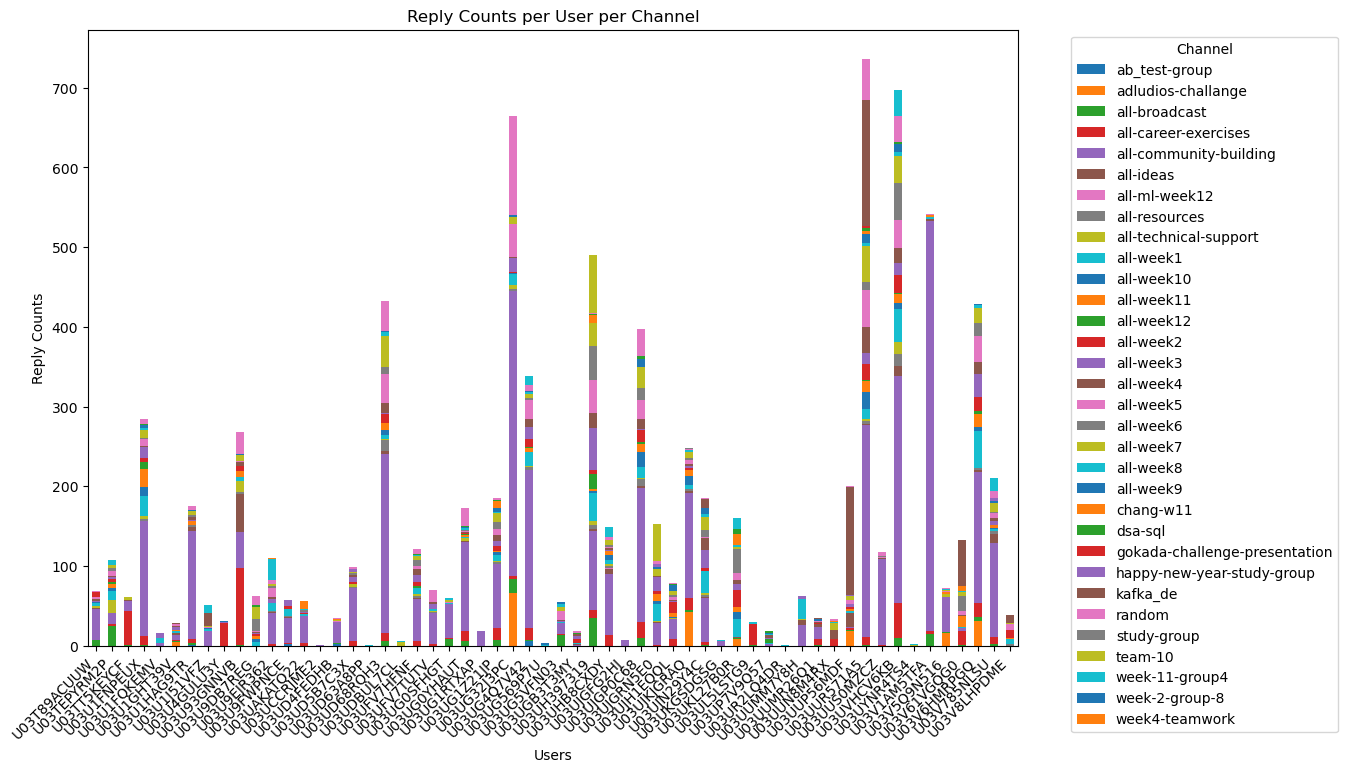

In [81]:
# Visualize reply counts per user per channel
#use this utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")

# construct df and plot

# Initialize a list to store data for each user and channel
data_list = []

# Iterate through channels
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.get_community_participation(f"{data_path}{channel_name}/")

    # Update data_list with counts for the current channel
    for user, reply_count in mp_data.items():
        data_list.append({'User': user, 'Channel': channel_name, 'ReplyCount': reply_count})

# Create a dataframe from the list
df = pd.DataFrame(data_list)

# Pivot the dataframe to have users as rows, channels as columns, and reply counts as values
pivot_df = df.pivot_table(index='User', columns='Channel', values='ReplyCount', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', ax=ax, stacked=True)
ax.set_xlabel('Users')
ax.set_ylabel('Reply Counts')
ax.set_title('Reply Counts per User per Channel')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [144]:
import warnings
warnings.filterwarnings('ignore')
# what is the time range of the day that most messages are sent?

#get sent message with time, then group the with time 
# get_messages_from_channel use this function from utils

# Initialize an empty DataFrame
merged_df = pd.DataFrame(columns=['timestamp'])


#loop though channels
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.get_messages_from_channel(f"{data_path}{channel_name}/")
    for a in mp_data['ts']:
        # Convert the list to a DataFrame
        df = pd.DataFrame({'timestamp': pd.to_datetime(a, unit='s')})

        # Concatenate the current DataFrame to the merged DataFrame
        merged_df = pd.concat([merged_df, df], ignore_index=True)


# Sort the DataFrame based on the timestamp
merged_df = merged_df.sort_values(by='timestamp')

# Calculate the time differences between consecutive messages
merged_df['time_diff'] = merged_df['timestamp'].diff()

# Find the index of the maximum time difference (largest gap)
max_gap_index = merged_df['time_diff'].idxmax()

# Extract the start and end timestamps of the time range with the largest gap
start_time = merged_df.loc[max_gap_index, 'timestamp']
end_time = merged_df.loc[max_gap_index + 1, 'timestamp']

# Print the result
print(f"The largest gap in messages occurred between {start_time} and {end_time}")


Number of messages in channel: 79
Number of messages in channel: 29
Number of messages in channel: 73
Number of messages in channel: 84
Number of messages in channel: 81
Number of messages in channel: 66
Number of messages in channel: 15
Number of messages in channel: 83
Number of messages in channel: 3
Number of messages in channel: 8
Number of messages in channel: 11
Number of messages in channel: 1
Number of messages in channel: 8
Number of messages in channel: 5
Number of messages in channel: 18
Number of messages in channel: 8
Number of messages in channel: 2
Number of messages in channel: 4
Number of messages in channel: 3
Number of messages in channel: 9
Number of messages in channel: 1
Number of messages in channel: 7
Number of messages in channel: 8
Number of messages in channel: 7
Number of messages in channel: 13
Number of messages in channel: 7
Number of messages in channel: 7
Number of messages in channel: 8
Number of messages in channel: 8
Number of messages in channel: 1

In [83]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?